In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Prepare data

In [18]:
df_master = pd.read_csv('master.csv')
df_master['branch'] = 'master'

df_new = pd.read_csv('new-algorithm.csv')
df_new['branch'] = 'new-algorithm'

df = pd.concat([df_master, df_new], ignore_index = True)

## CPU time

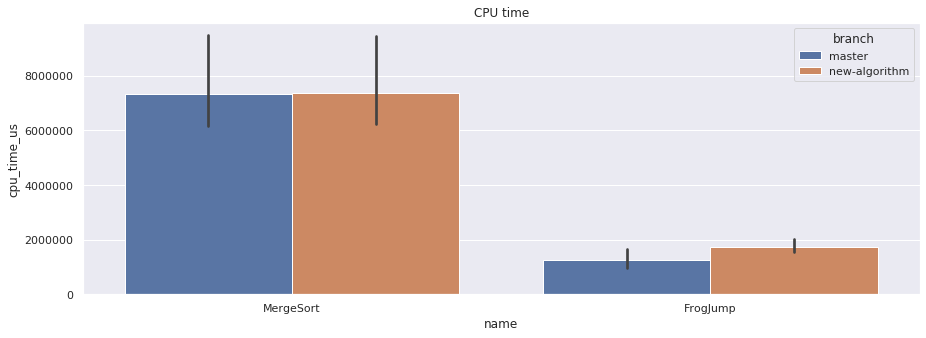

In [19]:
fig1, ax1 = plt.subplots(figsize=(15,5))
ax1.set_title('CPU time')
ax1.set_ylabel('Active time [us]')
ax1.set_xlabel('Algorithm')

sns.barplot(x='name', y='cpu_time_us', hue='branch', data=df);

## Energy

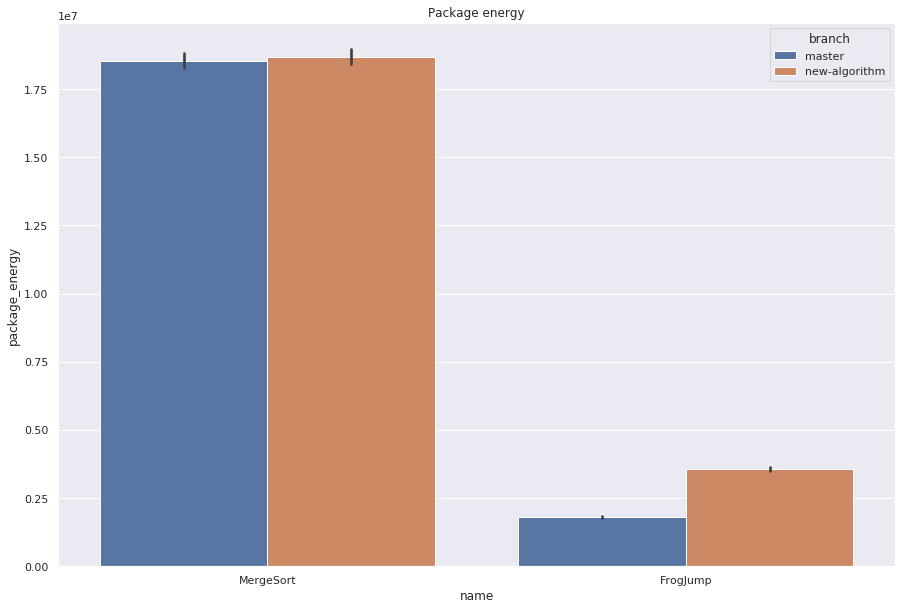

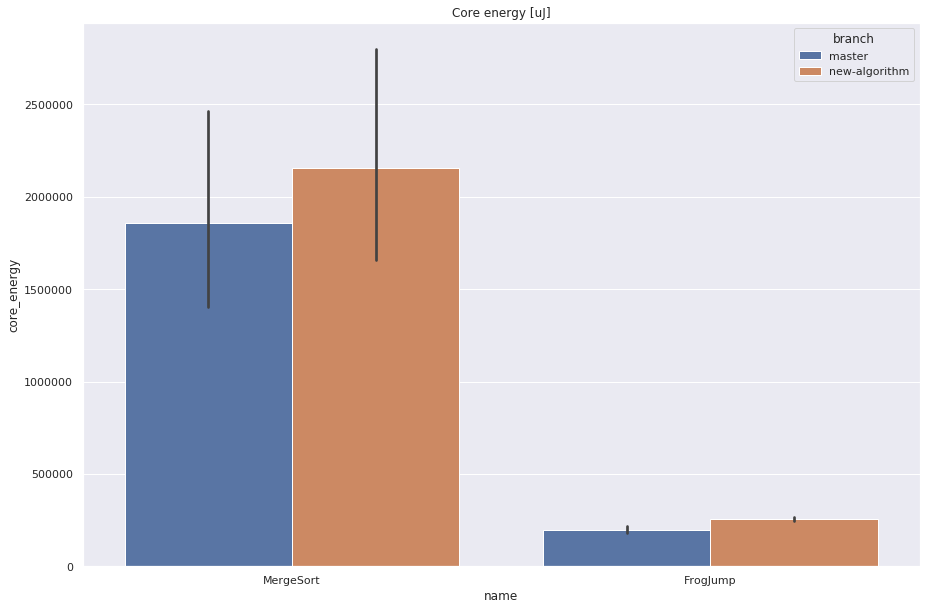

In [20]:
fig2, ax2 = plt.subplots(1, figsize=(15, 10));

ax2.set_title('Package energy')
ax2.set_ylabel('Energy [uJ]')
ax2.set_xlabel('Sleep duration [us]')
sns.barplot(x='name', y='package_energy', hue='branch', data=df);

fig2, ax3 = plt.subplots(1, figsize=(15, 10));

ax3.set_title('Core energy [uJ]')
ax3.set_ylabel('Energy [uJ]')
ax3.set_xlabel('Sleep duration [us]')
sns.barplot(x='name', y='core_energy', hue='branch', data=df);